In [41]:
# Importing necessary libraries and the data and helping functions
import os
import pandas as pd
import numpy as np
from datetime import datetime as dt
from __future__ import division

os.getcwd()
os.chdir('C:\\Users\\dhrugarg\\Desktop\My Resume\DoorDash\Data Science\Data Science')

Data = pd.read_csv('historical_data.csv', sep = ",", parse_dates =[1,2])

#### Functions used ###

# Summary function
def ds_summry(Mod_df_2):
    msng = ((Mod_df_2.isnull().sum()/len(Mod_df_2))*100).apply(round,args=(2,))
    uniq,max_v,min_v = Mod_df_2.nunique(),Mod_df_2.max(),Mod_df_2.min()
    df_stats = pd.concat([msng, uniq,max_v,min_v], axis=1).rename(index=str, 
                                                                  columns={0: "% missing", 1: "No_uniq",2:'Max_Val',3:'Min_Val'})
    return df_stats
# Shift var creation 
def shift(x):
    if x >6 and x<12:
        return 1    # 'Morning'
    elif x >=12 and x<=17:
        return 2    #'Lunch'
    elif x >17 and x<24:
        return 3    #'Dinner'
    else:
        return 4    #'Early_Morning'

In [42]:
# Creating the Output Variable

# Creating field for Dependent/Output Variable
Data['Duration'] = Data['actual_delivery_time'] - Data['created_at']

# Only considering relevant variables
Mod_df = Data[['Duration',                                              # Dependent Variable
 'market_id','store_id','store_primary_category',                      # Store characterstics 
 'order_protocol','total_items','subtotal','num_distinct_items','min_item_price','max_item_price',  # Order characterstics 
 'total_onshift_dashers','total_busy_dashers','total_outstanding_orders',   # Delivery system Characterstics
 'estimated_order_place_duration','estimated_store_to_consumer_driving_duration']]   # Other model results

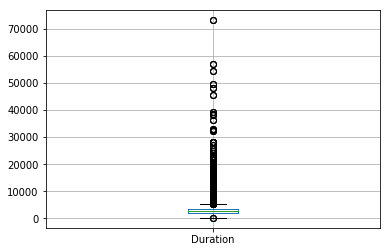

0 days 00:01:41 98 days 13:47:39
No cases with delivery time more than 3 hrs : 138
% cases with delivery time more than 3 hrs : 0.0698988998521


C:\Users\dhrugarg\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [43]:
# Getting the variables ready for modelling - Initiall Data Analysis (IDA)
import matplotlib.pyplot as plt
plt.show()
# Looking closely at Dependent Variable - Duration

print Mod_df['Duration'].min(),Mod_df['Duration'].max()
Mod_df['Duration'] = Mod_df['Duration'].dt.seconds

# Consideration 1 - We see that there are some cases with delivery time > 3 hrs looking at these oultiers below (>10800 secs)
Mod_df.boxplot(column = 'Duration')

print "No cases with delivery time more than 3 hrs : %d" %(len(Data[Mod_df['Duration']>10800]))
print "% cases with delivery time more than 3 hrs : {}".format((len(Data[Mod_df['Duration']>10800])/len(Mod_df))*100)

# Removing these cases from the dataset as its fair to assume that these are data log issues as a delivery time cannot be greater
# than 3 hours 

Mod_df_2 = Mod_df[Mod_df['Duration']<=10800]
#print len(Mod_df_2)

In [5]:
# Looking at the Independent variables 

# Checking all the variables for count of nan values and min max range of values to identify outliers in each

# Important observations: ##

# Total onshift/busy dashers and outstanding orders has significant missing values ~8.5% so we will use imputation tecniques
# to impute these values
# The min item price, onshift/busy dashers and outstanding orders all have negetive min values which dosen't make any sense. So 
# will assume that this is erronous data and consider them as missing values. All other min max values for variables look good 
# (within acceptable range) hence no need to look at boxplot distributions for them.

# Converting negetive values to NAN
Mod_df_2 = Mod_df_2.applymap(lambda x:x if x>=0 else float('nan'))

# Consideration 2 - Checking for busy dashers < onshift dashers as busy dashers is a subset of onshift dashers

bsy_onshft_chk = (len(Mod_df_2[Mod_df_2['total_busy_dashers']>Mod_df_2['total_onshift_dashers']])/len(Mod_df_2))*100

print "%d percent of the records have number of busy or onshift dashers mispopulated. Assuming that the total num of onshift dashers is \
mispopulated and should be equal to the busy dashers for these cases" %(bsy_onshft_chk)

ds_summry(Mod_df_2)

20 percent of the records have number of busy or onshift dashers mispopulated. Assuming that the total num of onshift dashers is mispopulated and should be equal to the busy dashers for these cases


,% missing,No_uniq,Max_Val,Min_Val
Duration,0.00,6999,10791,101
market_id,0.50,6,6,1
store_id,0.00,6742,ffedf5be3a86e2ee281d54cdc97bc1cf,0004d0b59e19461ff126e3a08a814c33
store_primary_category,2.41,74,vietnamese,inf
order_protocol,0.50,7,7,1
total_items,0.00,57,411,1
subtotal,0.00,8367,27100,0
num_distinct_items,0.00,20,20,1
min_item_price,0.01,2300,14700,0
max_item_price,0.00,2652,14700,0


In [6]:
# Converting store id and store primary category into numerical labels (Label encoding)
from sklearn import preprocessing
le_strid = preprocessing.LabelEncoder()
le_strid.fit(Mod_df_2['store_id'])
Mod_df_2['store_id_t'] = le_strid.transform(Mod_df_2['store_id'])

# Replacing missing values with 'miss' for store_primary_category before label encoding
Mod_df_2.loc[Mod_df_2['store_primary_category'].isnull(),'store_primary_category'] = 'miss'
le_str_ctg = preprocessing.LabelEncoder()
le_str_ctg.fit(Mod_df_2['store_primary_category'])
Mod_df_2['store_primary_category_t'] = le_str_ctg.transform(Mod_df_2['store_primary_category'])


# Imputing missing values for the rest of the variables

#order_protocol,market_id - Replacing missing values with 0 (creating a new class for missing apart from the 1-7/6 current class)
Mod_df_2.loc[Mod_df_2['order_protocol'].isnull(),'order_protocol'] = 0
Mod_df_2.loc[Mod_df_2['market_id'].isnull(),'market_id'] = 0

# min_item_price, total_busy_dashers, total_onshift_dashers, total_outstanding_orders, store_to_consumer_driving_duration     
# using the median values for imputation (less susceptible to outliers although we dont have any extreme ones)
for i in ['min_item_price','total_onshift_dashers','total_busy_dashers','total_outstanding_orders',
          'estimated_store_to_consumer_driving_duration']:
    
    Mod_df_2.loc[Mod_df_2[i].isnull(),i] = Mod_df_2[i].median()
    
# Correcting for no of onshift dashers < busy dashers 
Mod_df_2['total_onshift_dashers'] = np.where(Mod_df_2['total_busy_dashers']>Mod_df_2['total_onshift_dashers'],
                                             Mod_df_2['total_busy_dashers'],Mod_df_2['total_onshift_dashers'])

c = len(Mod_df_2[Mod_df_2['total_busy_dashers']>Mod_df_2['total_onshift_dashers']])
print "%d still mispopulated cases - Onshift/busy dashers" %(c)

0 still mispopulated cases - Onshift/busy dashers


In [7]:
# Checking missing value count now - All variables should be 0%
((Mod_df_2.isnull().sum()/len(Mod_df_2))*100).apply(round,args=(2,))

Duration                                        0.0
market_id                                       0.0
store_id                                        0.0
store_primary_category                          0.0
order_protocol                                  0.0
total_items                                     0.0
subtotal                                        0.0
num_distinct_items                              0.0
min_item_price                                  0.0
max_item_price                                  0.0
total_onshift_dashers                           0.0
total_busy_dashers                              0.0
total_outstanding_orders                        0.0
estimated_order_place_duration                  0.0
estimated_store_to_consumer_driving_duration    0.0
store_id_t                                      0.0
store_primary_category_t                        0.0
dtype: float64

In [8]:
# Feature Engineering ### - Creating features that could have strong predictive power based on logical hypothesis 

# Creating features to check how busy the resturant would be at a given time :

# Hypothesis - Delivery time is dependent on day of the week and time/hour of the order as this directly effects how busy a 
# resturant would be which affects the deliver time. Hence creating 3 new variables (Day, Hour, Shift)

# Appending back the datetime var's to create these features

Mod_df_3 = pd.concat([Mod_df_2,Data[['actual_delivery_time','created_at']]],axis = 1)
Mod_df_2['Deliv_Day'] = Mod_df_3['created_at'].dt.weekday
Mod_df_2['Deliv_hour'] = Mod_df_3['created_at'].dt.hour
        
Mod_df_2['Deliver_shift'] = Mod_df_2['Deliv_hour'].apply(shift)

### Creating synthetics to check how busy the delivery service or dashers are at any given time

# Var 1 - % of free dashers at any given time
Mod_df_2['%_Dashers_free'] = np.where((Mod_df_2['total_busy_dashers'] + Mod_df_2['total_onshift_dashers'] ==0) , 0,
                                      (1 - (Mod_df_2['total_busy_dashers']/Mod_df_2['total_onshift_dashers']))*100)

# Var2 - No of free dashers to no of outstanding orders at a given time
Mod_df_2['Free_Dash/Outdng_Orders'] = np.where((Mod_df_2['total_outstanding_orders'] ==0) , 0,
                                               (Mod_df_2['total_onshift_dashers'] - 
                                                Mod_df_2['total_busy_dashers'])/Mod_df_2['total_outstanding_orders'])

In [9]:
# Creating final modelling set and running summary stats on it once
Mod_df_2.drop(['store_primary_category','store_id'],axis = 1, inplace = True)
ds_summry(Mod_df_2)

,% missing,No_uniq,Max_Val,Min_Val
Duration,0.0,6999,10791.0,101.0
market_id,0.0,7,6.0,0.0
order_protocol,0.0,8,7.0,0.0
total_items,0.0,57,411.0,1.0
subtotal,0.0,8367,27100.0,0.0
num_distinct_items,0.0,20,20.0,1.0
min_item_price,0.0,2300,14700.0,0.0
max_item_price,0.0,2652,14700.0,0.0
total_onshift_dashers,0.0,168,171.0,0.0
total_busy_dashers,0.0,154,154.0,0.0


In [10]:
# Data Preperocessing before modelling

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = Mod_df_2.drop(['Duration'],axis = 1)
y = Mod_df_2[['Duration']]

# Breaking up into train test  set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=10)

# Scaling the X variables for train set
sc = preprocessing.StandardScaler().fit(X_train) #sc.mean_, sc.scale_
X_train_scl = sc.transform(X_train) 

In [11]:
# Using ensemble techniques - Random Forest and Gradient Boosting Regressor as the given the nature of the predictors both 
# continous and discrete(with very high arity) it makes sense to use tree based approaches. 

from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import operator

er_str = {}

# By experimenting with various cases of tree depth and max features at a node trying to find the optimum operation point and 
# account for the bias vs variance trade off

for feat, dep in [(2,2),(5,4),(8,6),(9,9),(12,11)]:  
    
    gbr = GradientBoostingRegressor(n_estimators =50, max_depth=dep, max_features = feat,
                                    random_state=0, learning_rate=0.01, loss='ls')
    rf = RandomForestRegressor(n_estimators =50,max_depth=dep,max_features = feat,random_state=0)
    
    for model,name in [(gbr,'Gradient Boosting Regressor'),(rf,'Random Forest Regressor')]:
        
        model.fit(X_train_scl, y_train) # Fitting both the models
        error = mean_squared_error(y_test, model.predict(sc.transform(X_test))) # Calculating the MSE on test set
        er_str[(name,(feat,dep))] = round(error,2)
        #print "MSE for model %s is : %d" %(name,error)
        print 'this completed %d' %(dep) 
        
er_str.items()

C:\Users\dhrugarg\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


this completed 2


C:\Users\dhrugarg\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


this completed 2
this completed 4
this completed 4
this completed 6
this completed 6
this completed 9
this completed 9
this completed 11
this completed 11


[(('Random Forest Regressor', (5, 4)), 992382.52),
 (('Random Forest Regressor', (8, 6)), 934539.35),
 (('Random Forest Regressor', (12, 11)), 841921.13),
 (('Random Forest Regressor', (9, 9)), 871536.17),
 (('Random Forest Regressor', (2, 2)), 1080965.67),
 (('Gradient Boosting Regressor', (2, 2)), 1129083.27),
 (('Gradient Boosting Regressor', (12, 11)), 975974.85),
 (('Gradient Boosting Regressor', (5, 4)), 1077611.7),
 (('Gradient Boosting Regressor', (9, 9)), 997505.35),
 (('Gradient Boosting Regressor', (8, 6)), 1037300.32)]

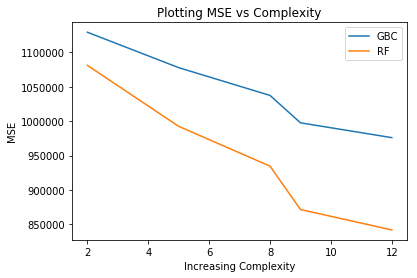

In [82]:
# Visualizing the model complexity vs MSE curve for both the models - to select the better performing model and operation point

comp_rf,comp_gbc = [],[]
for i in er_str.items():
    if i[0][0] == 'Random Forest Regressor':
        comp_rf.append((i[0][1][0],i[1]))
    else:
        comp_gbc.append((i[0][1][0],i[1]))
comp_rf_2 = sorted(comp_rf,key=operator.itemgetter((0)),reverse=False)
comp_gbc_2 = sorted(comp_gbc,key=operator.itemgetter((0)),reverse=False)

import matplotlib.pyplot as plt
a = plt.plot(*zip(*comp_gbc_2),label = 'GBM')
b = plt.plot(*zip(*comp_rf_2),label = 'RF')
plt.xlabel('Increasing Complexity(No_features_listed_here)')
plt.ylabel('MSE')
plt.title('Plotting MSE vs Complexity')
plt.legend()
plt.show()

# Conclusions - The RF consistently performs better than the GBM for various operation points even with varying model complexity.
# Also when max depth, no of trees = 2,2 for the models they are underfitting the data and as we increase complexity the models 
# perform signiificantly better. If we would increase the complexity even more the MSE would start to go up as the models would 
# begin overfitting. Hence features = 12 , depth = 11 is a good operating point for the model. I ran a couple of other points and 
# saw that when we increase the depth even by a large number to say 25 the MSE only decreases by a very small amount hence showing
# that depth = 11 is a good operation point as the slope of the line is very flat after this.

In [84]:
# Final model selected 
rf = RandomForestRegressor(n_estimators =50,max_depth=11,max_features = 12,random_state=0)
rf.fit(X_train_scl, y_train) 

# Analyzing the variable impt scores for the model that we chose
print "Variable Importance for selected RF model"
coeff = rf.feature_importances_.flatten().tolist()
coeff = map(abs,coeff)
coeff_dict={}
for i in range(len(coeff)):
    coeff_dict[X.columns[i]]=coeff[i]
sorted_coeff_dict = sorted(coeff_dict.items(),key=operator.itemgetter((1)),reverse=True)
for x in sorted_coeff_dict:
    print x
# Interesting to see that some of our hypthesis were validated and some of the synthetic variables that I created came out to 
# be pretty important predictors. For example delivery hour (second most imp) abd Free dash/outs orders it means resturant 
# busyness and no of dashers out there in respect to outstanding orders are important predictors.

C:\Users\dhrugarg\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Variable Importance for selected RF model
('estimated_store_to_consumer_driving_duration', 0.17544703211239732)
('Deliv_hour', 0.17206255726853925)
('Free_Dash/Outdng_Orders', 0.10749766886740392)
('subtotal', 0.1019037306617183)
('total_outstanding_orders', 0.09116480197141681)
('total_onshift_dashers', 0.0671331905495492)
('Deliv_Day', 0.0466277396493623)
('total_busy_dashers', 0.04360223994068066)
('%_Dashers_free', 0.03127371565307792)
('max_item_price', 0.027798176085554474)
('market_id', 0.026829084464621858)
('store_id_t', 0.02324228868592164)
('min_item_price', 0.01914841049614975)
('store_primary_category_t', 0.01415170508538722)
('estimated_order_place_duration', 0.014023457751841842)
('num_distinct_items', 0.012026808033961502)
('order_protocol', 0.012001195644430187)
('total_items', 0.011248434235744835)
('Deliver_shift', 0.0028177628422409486)


In [32]:
# MSE if we predicted the mean (Default model):
Mse_def = ((y_test - y_train.mean())**2).sum()/len(y_test)
MSE_model = 841921.13
Prcnt_reduction_MSE = ((Mse_def[0] - MSE_model)/Mse_def[0])*100
print 'The model created was able to reduce the MSE by: %d percnt on the test set compared to the default model' %(Prcnt_reduction_MSE)

The model created was able to reduce the MSE by: 28 percnt on the test set compared to the default model


In [88]:
# Saving/Outputting the model and other required files as a pkl file
import pickle
os.chdir('C:\Users\dhrugarg\Documents\Python Scripts\DoorDash_Test_Files')
pickle.dump(rf,open('Doordash_Final_model_rf.sav','wb'))
# pickle.dump(le_strid,open('Label_enc_storeid.sav','wb'))
# pickle.dump(le_str_ctg,open('Label_store_prm_ctgy.sav','wb'))
# pickle.dump(sc,open('Scalling_coef.sav','wb'))